In [6]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xskillscore
from defs import trim_axs, amocstrength, corsst, pvalmask, lon180, makedz, amocstrength_100yr, merid_gradient, N_avg, S_avg
import matplotlib as mpl
import gsw
import scipy

In [7]:
folder = '/Volumes/External/DataPlioMIP2/Data/Processed/'
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [8]:
#Compute PmE for all models at the Atlantic Ocean surface

#This mask has been saved from Fig05Fig06FigS09.ipynb
maskds = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/1x1Atlmask.nc')
mask_Atl_reg = maskds.region

ds1 = xr.open_dataset('/Volumes/External/DataPlioMIP2/Data/Processed/PmEE280.nc')
ds2 = xr.open_dataset('/Volumes/External/DataPlioMIP2/Data/Processed/PmEEoi400.nc')

weights = np.cos(np.deg2rad(ds1.lat)) #Use latitudinal weights for averaging
weights.name = "weights"

a = ds1.pme.where(mask_Atl_reg>-1).where(ds1.lat>=45).where(ds1.lat<=65).where(ds1.lon<-30).weighted(weights).mean(dim=['lon','lat'])
c = ds2.pme.where(mask_Atl_reg>-1).where(ds1.lat>=45).where(ds1.lat<=65).where(ds1.lon<-30).weighted(weights).mean(dim=['lon','lat'])

pmedif = c-a

In [9]:
#Open sea surface salinity fields saved from Fig05Fig06FigS09.ipynb
ds1 = xr.open_dataset(folder+'/sssE280.nc')
sssE280 = ds1.sss

ds2 = xr.open_dataset(folder+'/sssEoi400.nc')
sssEoi400 = ds2.sss

a = ds1.sss.where(mask_Atl_reg>-1).where(ds1.lat>=45).where(ds1.lat<=65).where(ds1.lon<-30).weighted(weights).mean(dim=['lon','lat'])
c = ds2.sss.where(mask_Atl_reg>-1).where(ds1.lat>=45).where(ds1.lat<=65).where(ds1.lon<-30).weighted(weights).mean(dim=['lon','lat'])

sssdif = c-a

In [12]:
# Load FW transport through sections
transports = np.load(folder+'transports.npz')
fwlab = transports['array1'][2] #mPWP-PI anomaly in FW transport into the Labrador Sea
fwfram = transports['array2'][2] #mPWP-PI anomaly in FW transport across the Fram Strait

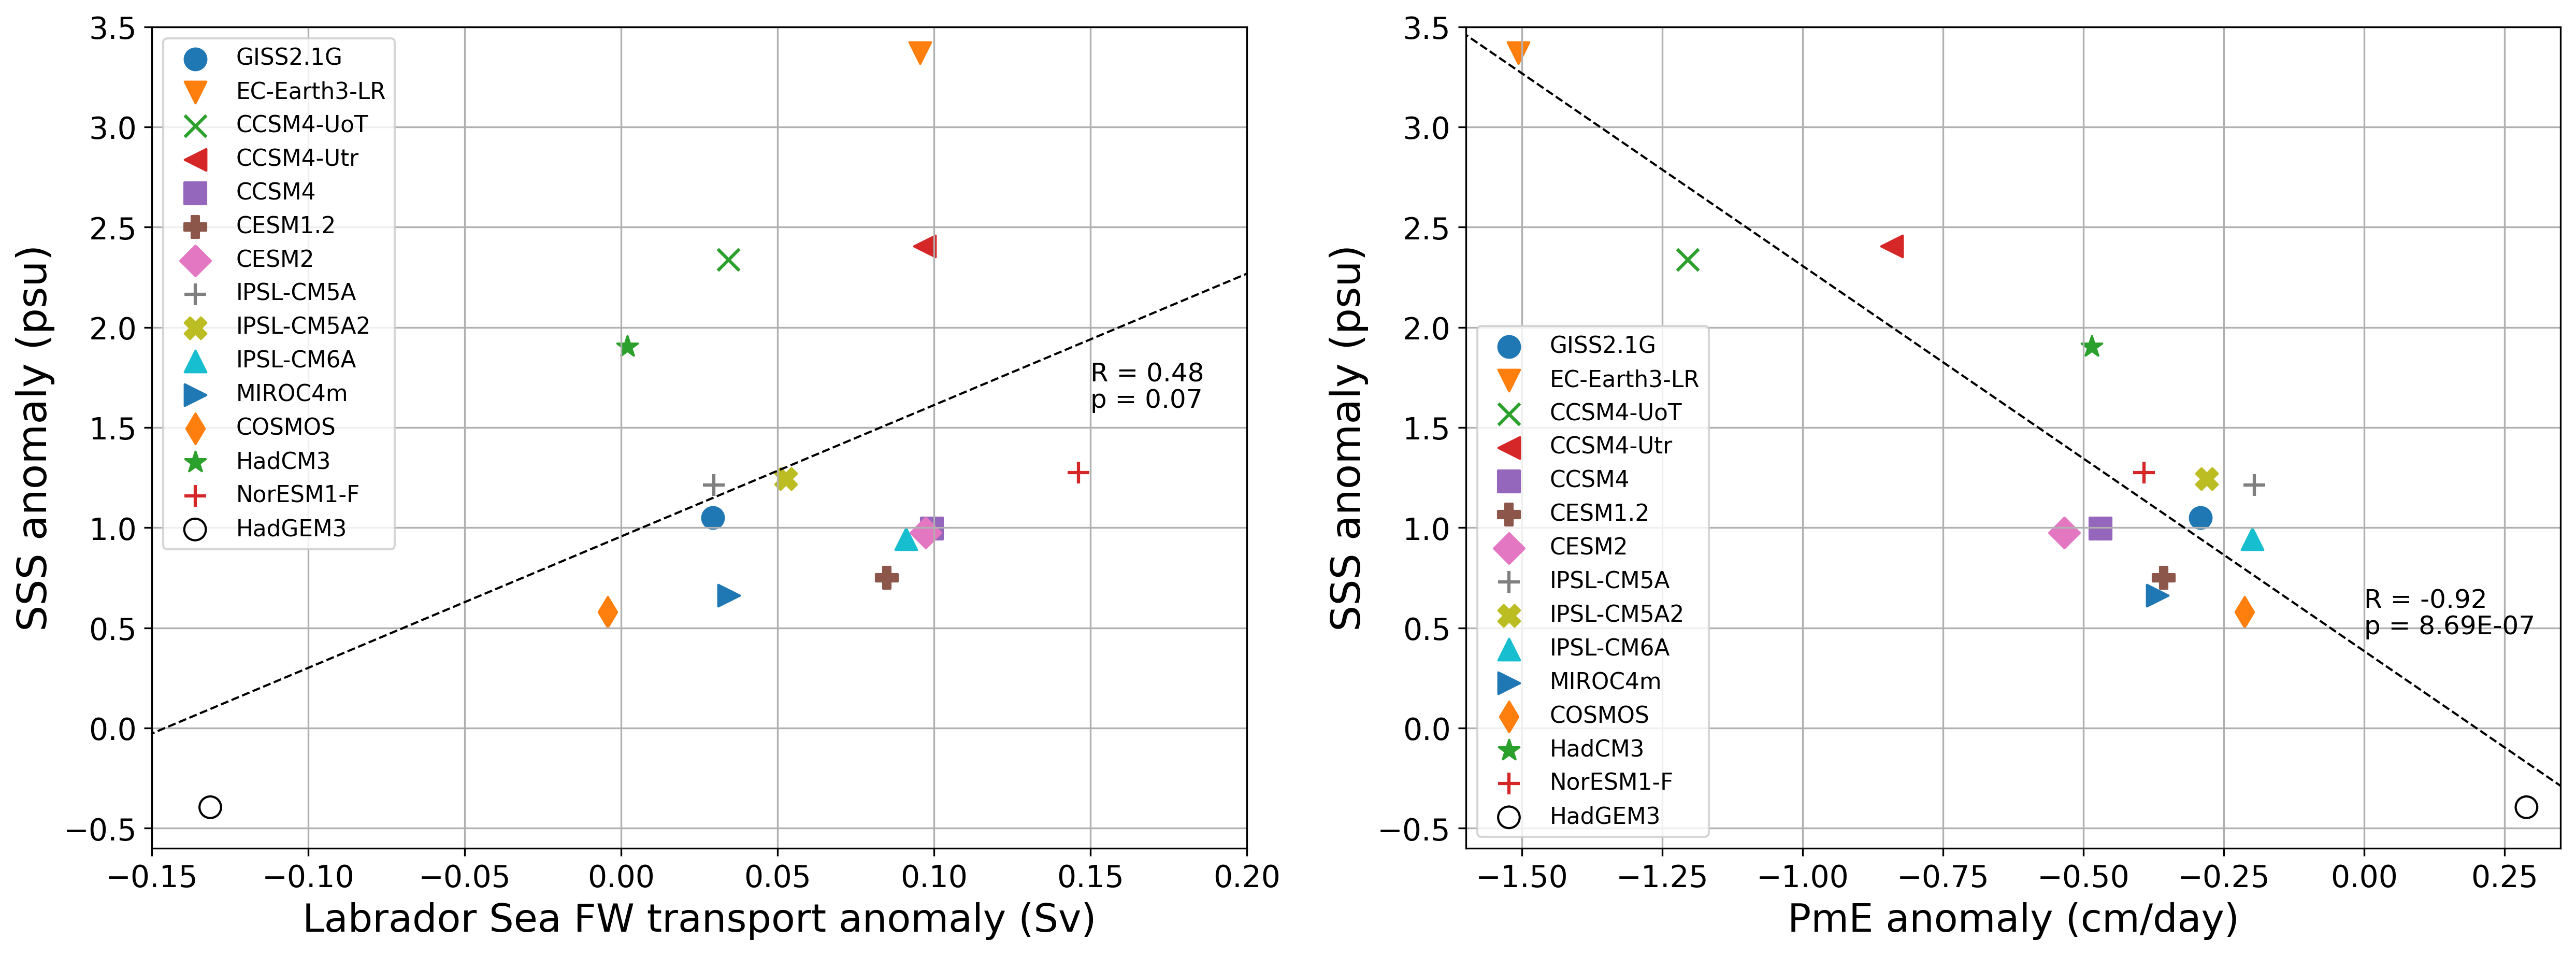

In [13]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 19

x = np.arange(-5,10,0.1)

markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
fig, ax = plt.subplots(1, 2, figsize=(20,7), dpi=300)

#Perform linear regression between AMOC anomaly and total/overturning OHT anomaly
p = scipy.stats.linregress(fwlab, sssdif)
p1 = scipy.stats.linregress(pmedif, sssdif)

for j in range(0,len(modellist)-1):
    scatter = ax[0].scatter(fwlab[j], sssdif[j], s=100, c = 'C'+str(j), label=modellist[j], marker=markers[j])
    scatter2 = ax[1].scatter(pmedif[j], sssdif[j], s=100, c='C'+str(j), label=modellist[j], marker=markers[j])

ax[0].scatter(fwlab[-1], sssdif[-1], s=100, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
ax[1].scatter(pmedif[-1], sssdif[-1], s=100, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])

ax[0].plot(x, x*p[0]+p[1], color='black',linewidth =1, linestyle ='--')    
ax[0].text(0.15,1.73,'R = %.2f' %(p[2]), fontsize=12)
ax[0].text(0.15,1.6, 'p = %.2f' %(p[3]), fontsize=12)
ax[1].plot(x, x*p1[0]+p1[1], color='black',linewidth =1, linestyle ='--')
ax[1].text(0,0.6,'R = %.2f' %(p1[2]), fontsize=12)
ax[1].text(0,0.47,'p = %.2E' %(p1[3]), fontsize=12)

for i in range(0,2):
    #ax[i].plot([-30, 60], [0, 0], color='black',linewidth =1, linestyle ='-')
    #ax[i].plot([0, 0], [-50, 150], color='black',linewidth =1, linestyle ='-')
    ax[i].set_ylim([-0.6, 3.5])
    ax[i].set_ylabel('SSS anomaly (psu)')
ax[0].set_xlim([-0.15, 0.2])
ax[1].set_xlim([-1.6, 0.35])

ax[0].legend(loc='upper left', fontsize=10.5)
ax[1].legend(loc='lower left', fontsize=10.5)
ax[0].grid()
ax[1].grid()

ax[0].set_xlabel(r'Labrador Sea FW transport anomaly (Sv)', fontsize=18)
ax[1].set_xlabel(r'PmE anomaly (cm/day)', fontsize=18)

plt.savefig('fig09.png', bbox_inches='tight')